#### EDA part of the same notebook

In [1]:
import os
import sys
# Here you need to have same Python version on your local machine and on worker node i.e. EC2. here both should have python3.
#os.environ["PYSPARK_PYTHON"] = "/bin/python3"
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Credit').getOrCreate()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_application = spark.read.csv("application_record.csv", header=True, inferSchema=True)
#df_application = pd.read_csv("application_record.csv")
#df_application.limit(5).show()

In [5]:
df_application.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)



In [6]:
from pyspark.sql import functions as F

#### Checking which columns have a lot of null values

In [7]:
df_application.where(F.col("OCCUPATION_TYPE").isNull()).count()

134203

#### Why does OCCUPATION_TYPE have so many null entrues

In [8]:
df_application.groupby('OCCUPATION_TYPE').count().show()

+--------------------+------+
|     OCCUPATION_TYPE| count|
+--------------------+------+
|                null|134203|
|            Managers| 35487|
|            HR staff|   774|
|      Medicine staff| 13520|
|         Accountants| 15985|
|            Laborers| 78240|
|      Cleaning staff|  5845|
|Private service s...|  3456|
|             Drivers| 26090|
|         Sales staff| 41098|
|       Realty agents|  1041|
|            IT staff|   604|
|      Security staff|  7993|
|         Secretaries|  2044|
|  Low-skill Laborers|  2140|
|          Core staff| 43007|
|       Cooking staff|  8076|
|High skill tech s...| 17289|
|Waiters/barmen staff|  1665|
+--------------------+------+



#### Could be because a majority of them are retired and pension money is their only income.

###### Replacement to value_counts()

In [9]:
#df_application.groupBy('OCCUPATION_TYPE').count().orderBy('count').show()

In [10]:
df_application.where(F.col("OCCUPATION_TYPE").isNull()).select("NAME_INCOME_TYPE")\
.groupBy('NAME_INCOME_TYPE')\
.count()\
.orderBy('count', ascending = False).show()

+--------------------+-----+
|    NAME_INCOME_TYPE|count|
+--------------------+-----+
|           Pensioner|75357|
|             Working|35886|
|Commercial associate|16745|
|       State servant| 6210|
|             Student|    5|
+--------------------+-----+



### Filling all null entries in OCCUPATION_TYPE with "Not working"

In [11]:
from pyspark.sql.functions import isnan, when, count, col

In [12]:
df_application = df_application.fillna({'OCCUPATION_TYPE':'Not working'})

In [13]:
# number of null values in df_application
df_application.select([count(when(col(c).isNull(), c)).alias(c) for c in df_application.columns]).show(truncate=False)

+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|ID |CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|0  |0          |0           |0              |0           |0               |0               |0                  |0                 |0                |0         |0            |0         |0              |0         |0         |0    

### Checking outleir in number of children

In [14]:
df_application = df_application.where("CNT_CHILDREN !> 10")
print(df_application.count(), len(df_application.columns))

438549 18


df_application.drop(df_application[df_application['CNT_CHILDREN']>10].index, inplace =True)

### Outliers in DAYS_BIRTH / DAYS_EMPLOYEED

In [15]:
df_application.where('DAYS_BIRTH > 0').count()

0

df_application[df_application['DAYS_BIRTH']>0]

df_application[df_application['DAYS_EMPLOYED']>0]['NAME_INCOME_TYPE'].value_counts()

### Q1. Gender Demographic of the applicants

In [16]:
df_application.groupBy('CODE_GENDER').count().orderBy('count').show()
#df_application.groupBy('OCCUPATION_TYPE').count().orderBy('count').show()

+-----------+------+
|CODE_GENDER| count|
+-----------+------+
|          M|144114|
|          F|294435|
+-----------+------+



###### 67% of the applicants are females

### Q2. House ownership among applicants

In [17]:
df_application.select('FLAG_OWN_REALTY', 'CODE_GENDER').groupBy('CODE_GENDER', 'FLAG_OWN_REALTY').count().show()

+-----------+---------------+------+
|CODE_GENDER|FLAG_OWN_REALTY| count|
+-----------+---------------+------+
|          F|              N| 86302|
|          F|              Y|208133|
|          M|              Y| 95933|
|          M|              N| 48181|
+-----------+---------------+------+



##### House ownership is higher among females

### Q3. Correlation between income level and education level

##### Mapping the various levels of education to a number, to convert it to an integer type, then performing corr() on the dataframe,
##### reveals that there is a positive correlation betwen education level and income.

In [18]:
df_application.select("NAME_EDUCATION_TYPE").distinct().show(truncate=False)

+-----------------------------+
|NAME_EDUCATION_TYPE          |
+-----------------------------+
|Academic degree              |
|Incomplete higher            |
|Secondary / secondary special|
|Lower secondary              |
|Higher education             |
+-----------------------------+



In [19]:
education_map = {'Academic degree':5, \
                 'Incomplete higher':3, \
                 'Secondary / secondary special':2, \
                 'Lower secondary':1, \
                 'Higher education':4}

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

In [21]:
mapper = udf(lambda x: education_map[x])

In [22]:
df_application = df_application.withColumn('EDUCATION_MAP', mapper(df_application['NAME_EDUCATION_TYPE']))

##### Getting Correlation matrix

In [23]:
df_application.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = false)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- EDUCATION_MAP: string (nullable = true)



##### Change datatype of EDUCATION_MAP from string to Integer

In [24]:
from pyspark.sql.types import DoubleType
df_application = df_application.withColumn("EDUCATION_MAP", df_application['EDUCATION_MAP'].cast(IntegerType()))

##### Change Datatype of CNT_FAM_MEMBERS from double to Integer

In [25]:
df_application = df_application.withColumn("CNT_FAM_MEMBERS", df_application['CNT_FAM_MEMBERS'].cast(IntegerType()))

In [26]:
df_application = df_application.drop("NAME_EDUCATION_TYPE")

In [27]:
# Changing Datatype of INCOME to Integer type
df_application = df_application.withColumn("AMT_INCOME_TOTAL", df_application['AMT_INCOME_TOTAL'].cast(IntegerType()))

In [28]:
df_application.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: integer (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = false)
 |-- CNT_FAM_MEMBERS: integer (nullable = true)
 |-- EDUCATION_MAP: integer (nullable = true)



In [29]:
corr = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', \
        'DAYS_BIRTH', 'DAYS_EMPLOYED', \
        'FLAG_MOBIL', 'FLAG_WORK_PHONE', \
        'FLAG_PHONE', 'FLAG_EMAIL', \
        'CNT_FAM_MEMBERS', 'EDUCATION_MAP']

In [30]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [31]:
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

In [32]:
correlation_matrix(df_application, corr)

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,EDUCATION_MAP
CNT_CHILDREN,1.000000,0.019034,0.350098,-0.242140,NaN,0.038563,-0.038304,0.028662,0.884340,0.038042
AMT_INCOME_TOTAL,0.019034,1.000000,0.053772,-0.141287,NaN,-0.033625,0.004456,0.112145,0.011310,0.221414
DAYS_BIRTH,0.350098,0.053772,1.000000,-0.617909,NaN,0.171826,-0.037987,0.096754,0.306707,0.154552
DAYS_EMPLOYED,-0.242140,-0.141287,-0.617909,1.000000,NaN,-0.232212,0.004865,-0.074375,-0.234709,-0.120346
FLAG_MOBIL,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
FLAG_WORK_PHONE,0.038563,-0.033625,0.171826,-0.232212,NaN,1.000000,0.290058,-0.060916,0.049897,0.016055
FLAG_PHONE,-0.038304,0.004456,-0.037987,0.004865,NaN,0.290058,1.000000,-0.001173,-0.024193,0.036007
FLAG_EMAIL,0.028662,0.112145,0.096754,-0.074375,NaN,-0.060916,-0.001173,1.000000,0.022189,0.102167
CNT_FAM_MEMBERS,0.884340,0.011310,0.306707,-0.234709,NaN,0.049897,-0.024193,0.022189,1.000000,0.025808
EDUCATION_MAP,0.038042,0.221414,0.154552,-0.120346,NaN,0.016055,0.036007,0.102167,0.025808,1.000000


##### There is a correlation between education level and income, higher the education, higher the income

### Q4. Average and median salary of the applicant

#### mean = 187522.832 ; median = 162000

In [33]:
from pyspark.sql.functions import mean as _mean, col

In [34]:
df_application.select(_mean(col('AMT_INCOME_TOTAL'))).show()

+---------------------+
|avg(AMT_INCOME_TOTAL)|
+---------------------+
|    187522.8322285537|
+---------------------+



#### Median of AMT_INCOME_TOTAL

In [35]:
df_application.approxQuantile('AMT_INCOME_TOTAL', [0.5], 0.05)

[162000.0]

# Analysing credit dataframe

In [36]:
df_credit = spark.read.csv('credit_record.csv', header =True, inferSchema=True)
#df_credit.limit(5).show()

In [37]:
status_map = {'5':-6, '4':-5, '3':-4, '2':-3, '1':-2, '0':-1, 'C':0, 'X':1}

In [38]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

In [39]:
# Mapping the STATUSes to a predefined index, since it is an ordinal variable
mapper = udf(lambda x: status_map[x])

df_credit = df_credit.withColumn('STATUS_INDEX', mapper(df_credit['STATUS']))

In [40]:
# The datatype of that STATUS_INDEX is string, SO convert it to Integer type
df_credit = df_credit.withColumn("STATUS_INDEX", df_credit['STATUS_INDEX'].cast(IntegerType()))

In [41]:
# Dropping redundant column
df_credit = df_credit.drop("STATUS")

In [42]:
# Getting all Distinct Customers into a list
customer_ids = df_credit.select('ID').distinct().collect()

customer_ids = [int(row.ID) for row in customer_ids]

In [43]:
# Number of unique customers
len(customer_ids)

45985

In [44]:
# Create a dataframe with all late payments. 
# All payments taking more than 30 days (-1) can be considered as late payment
late_payment_df = df_credit.select('ID', 'STATUS_INDEX').where("STATUS_INDEX <= -1").groupby('ID').count()
late_payment_df = late_payment_df.select(*(col(x).alias(x + '_df1') for x in late_payment_df.columns))

In [45]:
# Create a dataframe with Total number of payments made by each customer
total_payment_df = df_credit.groupby('ID').count()
total_payment_df = total_payment_df.select(*(col(x).alias(x + '_df2') for x in total_payment_df.columns))

In [46]:
# a temporary dataframe to work with the late payments to get all the customer who can be termed as LATE
temp = late_payment_df.join(total_payment_df, late_payment_df.ID_df1 == total_payment_df.ID_df2)

In [47]:
# Calculate the proportion of late/total_payments_made
temp = temp.withColumn("late_proportion", (F.col("count_df1")/F.col("count_df2")))

In [48]:
# A UDF to term all the customer whose (late/total_payments_made > 0.98) as late
mapper = udf(lambda x: 1 if x>0.98 else 0)
temp = temp.withColumn('LATE', mapper(temp['late_proportion']))

In [49]:
#temp.groupBy('LATE').count().orderBy('count').show()

In [50]:
# Converting collect() to list()
late_customers = temp.select(col("ID_df1").alias('ID')).where("LATE == 1").collect()

late_customers = [int(row.ID) for row in late_customers]

In [51]:
# Mapping all the late_customer to the original df_credits dataframe
mapper = udf(lambda x: 1 if x in late_customers else 0)
df_credit = df_credit.withColumn('LATE', mapper(df_credit['ID']))

#### value_counts() how many LATE and how many Not

In [52]:
# df_credit.groupBy("LATE").count().orderBy('count').show()
#temp.groupBy('LATE').count().orderBy('count').show()

In [53]:
# Drop redundant column
df_credit = df_credit.drop("MONTHS_BALANCE", "STATUS_INDEX")

In [54]:
# Drop duplicate rows. What remains is all the customer_ids who were marked as late or not
df_credit = df_credit.dropDuplicates()

In [55]:
df_credit = df_credit.select(col("ID").alias('ID_credit'), col("LATE"))

In [56]:
df_credit.limit(1).show()

+---------+----+
|ID_credit|LATE|
+---------+----+
|  5001796|   0|
+---------+----+



In [57]:
# join Application and Credit history dataframes on customer ids
df = df_credit.join(df_application, df_credit.ID_credit==df_application.ID)

In [58]:
df = df.drop("ID", "ID_credit", "FLAG_MOBIL")

### consider LATE is the target variable

### Q5. Is the proportion of bad customers higher for people who own cars?

In [59]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window

##### To get percentages of the occurances in a column with groupBy

In [60]:
df.groupBy(['FLAG_OWN_CAR', 'LATE']).count().withColumn('percentage', \
                                                        F.round(F.col('count') / F.sum('count')\
                                                                .over(Window.partitionBy()),3)).show()

+------------+----+-----+----------+
|FLAG_OWN_CAR|LATE|count|percentage|
+------------+----+-----+----------+
|           Y|   1| 1852|     0.051|
|           N|   0|19393|     0.532|
|           Y|   0|11988|     0.329|
|           N|   1| 3220|     0.088|
+------------+----+-----+----------+



##### No, of the people that own cars only 0.017 are bad customers whereas the proportion of bad customers who dont own a car is 0.036

### Q6. Do people living on rent have a higher proportion of bad customers compared to the rest of the population?

##### Thats not the case, the proportion of bad customers who live in rented house is not the highest of all other types of housing

In [61]:
df.groupBy("NAME_HOUSING_TYPE", "LATE").count()\
.withColumn('percentage', \
            F.round(F.col('count') / F.sum('count')\
                    .over(Window.partitionBy()), 3)).show()

+-------------------+----+-----+----------+
|  NAME_HOUSING_TYPE|LATE|count|percentage|
+-------------------+----+-----+----------+
|   Rented apartment|   1|   80|     0.002|
|    Co-op apartment|   0|  153|     0.004|
|Municipal apartment|   1|  147|     0.004|
|       With parents|   0| 1523|     0.042|
|    Co-op apartment|   1|   15|       0.0|
|   Rented apartment|   0|  495|     0.014|
|   Office apartment|   1|   45|     0.001|
|   Office apartment|   0|  217|     0.006|
|Municipal apartment|   0|  981|     0.027|
|  House / apartment|   0|28012|     0.768|
|       With parents|   1|  253|     0.007|
|  House / apartment|   1| 4532|     0.124|
+-------------------+----+-----+----------+



### Q7. Do single customers have a high proportion of bad customers compared to married customers?

In [62]:
df.groupBy("NAME_FAMILY_STATUS", 'LATE')\
.count().withColumn('percentage', \
                    F.round(F.col('count') / F.sum('count')\
                            .over(Window.partitionBy()),3)).show()

+--------------------+----+-----+----------+
|  NAME_FAMILY_STATUS|LATE|count|percentage|
+--------------------+----+-----+----------+
|           Separated|   1|  244|     0.007|
|               Widow|   0| 1317|     0.036|
|             Married|   0|21553|     0.591|
|      Civil marriage|   0| 2562|      0.07|
|Single / not married|   0| 4093|     0.112|
|      Civil marriage|   1|  383|     0.011|
|             Married|   1| 3495|     0.096|
|           Separated|   0| 1856|     0.051|
|               Widow|   1|  215|     0.006|
|Single / not married|   1|  735|      0.02|
+--------------------+----+-----+----------+



##### NO, the proportion of bad customers who are single is 0.008 , 
##### Proportion of bad customers who are married is 0.033

#### Credit status of Pensioners.
#### Majority of the Pensioners are not LATE on their payment

In [63]:
df.select("LATE").where("NAME_INCOME_TYPE == 'Pensioner'").groupBy('LATE').count().orderBy('count').show()

+----+-----+
|LATE|count|
+----+-----+
|   1|  860|
|   0| 5292|
+----+-----+



# WOE and IV value calculation

#### First convert all the float values to int type

In [64]:
df = df.withColumn("LATE", df['LATE'].cast(IntegerType()))

In [65]:
df_pandas = df.toPandas()

### using spearman correlation for monotomic binning

In [66]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [67]:
final_iv, IV = data_vars(df_pandas,df_pandas.LATE)

/home/ec2-user/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [68]:
final_iv.head()

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,CODE_GENDER,F,F,24429,3397.0,0.139056,21032.0,0.860944,0.669756,0.670214,-0.000685,9.526075e-07
1,CODE_GENDER,M,M,12024,1675.0,0.139305,10349.0,0.860695,0.330244,0.329786,0.001391,9.526075e-07
2,FLAG_OWN_CAR,N,N,22613,3220.0,0.142396,19393.0,0.857604,0.634858,0.617985,0.026937,1.216672e-03
3,FLAG_OWN_CAR,Y,Y,13840,1852.0,0.133815,11988.0,0.866185,0.365142,0.382015,-0.045173,1.216672e-03
4,FLAG_OWN_REALTY,N,N,11951,1627.0,0.136139,10324.0,0.863861,0.320781,0.328989,-0.025266,3.071833e-04


In [69]:
IV

,VAR_NAME,IV
0,AMT_INCOME_TOTAL,2.041860e-03
1,CNT_CHILDREN,4.946421e-04
2,CNT_FAM_MEMBERS,4.438522e-04
3,CODE_GENDER,9.526075e-07
4,DAYS_BIRTH,1.132718e-04
5,DAYS_EMPLOYED,4.936329e-03
6,EDUCATION_MAP,3.542516e-03
7,FLAG_EMAIL,5.597212e-04
8,FLAG_OWN_CAR,1.216672e-03
9,FLAG_OWN_REALTY,3.071833e-04


# Apply WOE values to the dataframe columns

In [70]:
transform_vars_list = df_pandas.columns.difference(['LATE'])
transform_prefix = 'new_'

In [71]:
transform_vars_list

Index(['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CODE_GENDER',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EDUCATION_MAP', 'FLAG_EMAIL',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE', 'FLAG_WORK_PHONE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object')

In [72]:
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            df_pandas[transform_prefix + var] = df_pandas[var].apply(lambda x: eval(replace_cmd))
        except:
            df_pandas[transform_prefix + var] = df_pandas[var].apply(lambda x: eval(replace_cmd1))

In [73]:
df_pandas.drop(transform_vars_list, axis = 1, inplace=True) 

In [74]:
df_spark = spark.createDataFrame(df_pandas)

In [75]:
df_spark = df_spark.withColumn("LATE", df_spark['LATE'].cast(IntegerType()))

In [76]:
df_spark.printSchema()

root
 |-- LATE: integer (nullable = true)
 |-- new_AMT_INCOME_TOTAL: double (nullable = true)
 |-- new_CNT_CHILDREN: double (nullable = true)
 |-- new_CNT_FAM_MEMBERS: double (nullable = true)
 |-- new_CODE_GENDER: double (nullable = true)
 |-- new_DAYS_BIRTH: double (nullable = true)
 |-- new_DAYS_EMPLOYED: double (nullable = true)
 |-- new_EDUCATION_MAP: double (nullable = true)
 |-- new_FLAG_EMAIL: double (nullable = true)
 |-- new_FLAG_OWN_CAR: double (nullable = true)
 |-- new_FLAG_OWN_REALTY: double (nullable = true)
 |-- new_FLAG_PHONE: double (nullable = true)
 |-- new_FLAG_WORK_PHONE: double (nullable = true)
 |-- new_NAME_FAMILY_STATUS: double (nullable = true)
 |-- new_NAME_HOUSING_TYPE: double (nullable = true)
 |-- new_NAME_INCOME_TYPE: double (nullable = true)
 |-- new_OCCUPATION_TYPE: double (nullable = true)



# Now that we have the dataframe with WOE values for all the features, we can build a model for it

### First, Its better to write this final dataframe to csv file for faster access in the future

df_spark.coalesce(1).write.option("header", "true").parquet("./DATAFRAME_CHECKPOINTS/df_new.parquet")

df_spark.coalesce(1).write.csv('WOE_CSV_new.csv', header = True)

In [78]:
df_spark = spark.read.parquet('./DATAFRAME_CHECKPOINTS/df_new.parquet')

In [79]:
df_spark.count()

36453

In [80]:
df_spark.groupBy('LATE').count().orderBy('count').show()

+----+-----+
|LATE|count|
+----+-----+
|   1| 5072|
|   0|31381|
+----+-----+



## Logistic Model building

In [81]:
from pyspark.ml.feature import VectorAssembler

In [82]:
trainCols = df_spark.columns

In [83]:
# columns to use in training the model, removing the target variable
trainCols.remove('LATE')

In [84]:
# configure the assembler object and use it to transform df_spark
assembler = VectorAssembler(inputCols = trainCols, outputCol='features')
df_assembler = assembler.transform(df_spark)

In [85]:
np.random.seed(0)

In [86]:
df_train, df_test = df_assembler.randomSplit([0.8, 0.2])

In [87]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='LATE')
model = lr.fit(df_train)

In [88]:
result_test = model.evaluate(df_test)

## Since this is vert close to 0.5, it can be interpretted that this model has very less class separation power

In [89]:
result_test.areaUnderROC

0.5395763064231398

## Finding the right threshold

In [90]:
# result_test columns
result_test.predictions

DataFrame[LATE: int, new_AMT_INCOME_TOTAL: double, new_CNT_CHILDREN: double, new_CNT_FAM_MEMBERS: double, new_CODE_GENDER: double, new_DAYS_BIRTH: double, new_DAYS_EMPLOYED: double, new_EDUCATION_MAP: double, new_FLAG_EMAIL: double, new_FLAG_OWN_CAR: double, new_FLAG_OWN_REALTY: double, new_FLAG_PHONE: double, new_FLAG_WORK_PHONE: double, new_NAME_FAMILY_STATUS: double, new_NAME_HOUSING_TYPE: double, new_NAME_INCOME_TYPE: double, new_OCCUPATION_TYPE: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [91]:
thresh = result_test.predictions.select('LATE', 'probability')

In [92]:
# creating a function to access the probability of the positive class
from pyspark.sql.functions import udf, when
from pyspark.sql.types import FloatType
element_extrac = udf(lambda v: float(v[1]), FloatType())

In [126]:
# creating a list of all thresholds to check the metrics for
result_list = []
threshold_list = [0.1, 0.2, 0.25]

In [127]:
# Need to add a task column, by comparing the probabilities with threshold
for i in threshold_list:
    test_pred = thresh.withColumn('label_p',when(element_extrac(thresh["probability"]) >= i, 1).otherwise(0))
    TP = test_pred.filter("LATE==1 AND label_p==1").count()
    FP = test_pred.filter("LATE==0 AND label_p==1").count()
    FN = test_pred.filter("LATE==1 AND label_p==0").count()
    TN = test_pred.filter("LATE==0 AND label_p==0").count()    
    recall = (TP/(TP+FN))
    precision = ((TP/(TP+FP)))
    list1 = []
    list1.append(i)
    list1.append(precision)
    list1.append(recall)
    list1.append(TP)
    list1.append(TN)
    list1.append(FP)
    list1.append(FN)
    result_list.append(list1)

In [95]:
from pyspark.sql.types import *

schema = StructType([StructField('threshold', FloatType(), True),
                      StructField('precision', FloatType(), True),
                      StructField('recall', FloatType(), True),
                      StructField('TP', IntegerType(), True),
                      StructField('TN', IntegerType(), True),
                      StructField('FP', IntegerType(), True),
                      StructField('FN', IntegerType(), True)])
#create a rdd from the list
rdd = spark.sparkContext.parallelize(result_list)


# create a spark dataframe form rdd
thresh_df = spark.createDataFrame(rdd,schema)

# create pandas dataframe form the spark dataframe 
pandas_df = thresh_df.toPandas()

UsageError: Line magic function `%matplot` not found.


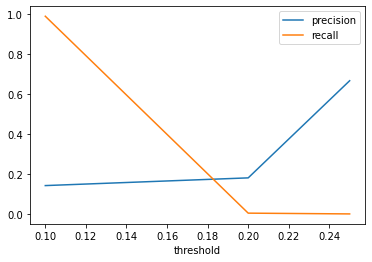

In [96]:
# import matplot lib 
import matplotlib.pyplot as plt

# create the plot
pandas_df.plot.line(x='threshold', y=['precision','recall'])

# display the plot
%matplot plt

In [97]:
total_number = thresh.count()
positives = thresh.filter("LATE==1").count()

# KS Statistic

#### predicted Probabilty dataframe from the model

In [98]:
probability_df = result_test.predictions.select('LATE','probability')

In [99]:
prob_test_pred = probability_df.withColumn('label_p',element_extrac(probability_df["probability"]))


In [100]:
# converting dataframe to pandas
pandas_prob_df = prob_test_pred.toPandas()

In [101]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    #print(kstable)
    
    #Display KS
    #from colorama import Fore
    #print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [102]:
ks_df = ks(data=pandas_prob_df,target="LATE", prob="label_p")

In [103]:
ks_df

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.161237,0.261896,124,610,11.91%,9.70%,11.91%,9.70%,2.2
2,0.151355,0.161200,111,620,10.66%,9.86%,22.57%,19.55%,3.0
3,0.147785,0.151340,105,630,10.09%,10.01%,32.66%,29.57%,3.1
4,0.143933,0.147761,120,603,11.53%,9.59%,44.19%,39.15%,5.0
5,0.138927,0.143917,98,645,9.41%,10.25%,53.60%,49.40%,4.2
6,0.134125,0.138924,119,614,11.43%,9.76%,65.03%,59.16%,5.9
7,0.129115,0.134105,104,629,9.99%,10.00%,75.02%,69.16%,5.9
8,0.123664,0.129105,87,646,8.36%,10.27%,83.38%,79.43%,4.0
9,0.116012,0.123643,95,638,9.13%,10.14%,92.51%,89.57%,2.9


In [104]:
ks_df['KS'].max()

5.8999999999999995

In [130]:
prob_thresh = ks_df[ks_df['KS']==ks_df['KS'].max()]['min_prob']

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
6,0.134125,0.138924,119,614,11.43%,9.76%,65.03%,59.16%,5.9
7,0.129115,0.134105,104,629,9.99%,10.00%,75.02%,69.16%,5.9


In [131]:
prob_thresh = 0.134125

### The KS value is 5.9 at 6th decile, and the probability threshold is 0.134125

## Confusion matrix

In [132]:
threshold = result_test.predictions.select('LATE', 'probability')

In [133]:
threshold.show()

+----+--------------------+
|LATE|         probability|
+----+--------------------+
|   0|[0.89757829248968...|
|   0|[0.89906681399244...|
|   0|[0.88438826919996...|
|   0|[0.89869190762930...|
|   0|[0.88346659016632...|
|   0|[0.88346659016632...|
|   0|[0.89683463410314...|
|   0|[0.89683463410314...|
|   0|[0.90986401639170...|
|   0|[0.90986401639170...|
|   0|[0.88841225186886...|
|   0|[0.89458204637549...|
|   0|[0.89639637890635...|
|   0|[0.88879267076089...|
|   0|[0.88784235961363...|
|   0|[0.88784235961363...|
|   0|[0.88784235961363...|
|   0|[0.88784235961363...|
|   0|[0.88784235961363...|
|   0|[0.88784235961363...|
+----+--------------------+
only showing top 20 rows



In [142]:
prob_thresh

0.134125

In [153]:
# creating a list of all thresholds to check the metrics for
result_list_new = []
threshold_list = [prob_thresh]

# Need to add a task column, by comparing the probabilities with threshold
for i in threshold_list:
    pred = threshold.withColumn('label_p',when(element_extrac(threshold["probability"]) >= i, 1).otherwise(0))
    TP = pred.filter("LATE==1 AND label_p==1").count()
    FP = pred.filter("LATE==0 AND label_p==1").count()
    FN = pred.filter("LATE==1 AND label_p==0").count()
    TN = pred.filter("LATE==0 AND label_p==0").count()    
    recall = (TP/(TP+FN))
    precision = ((TP/(TP+FP)))
    x = []
    x.append(i)
    x.append(precision)
    x.append(recall)
    x.append(TP)
    x.append(TN)
    x.append(FP)
    x.append(FN)
    result_list_new.append(x)

## Confusion matrix

In [154]:
result_list_new

[[0.134125, 0.15389861332120935, 0.6503362151777138, 677, 2569, 3722, 364]]

## F1 Score

In [155]:
F1 = 2*(precision*recall)/(precision+recall)

In [156]:
F1

0.24889705882352942